In [32]:

import torch
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random
import scipy.sparse
from scipy import stats
from scipy import fftpack
from infer_pK_Kt_bytype import optimalLearningParallel
import pickle

In [33]:
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [41]:
#Try to fit parameters of MaxEnt with TA code
#Load spikes, possibly in the form NxB
d = load_dict("myspikes.npy")
r = d['5']
#r = r.reshape(-1,r.shape[-1]).transpose()

In [42]:
#Parameters for fitting
N,B = r.shape
Bmin = B
logTd = 5
nWork=1
nStepMore = 10
eta = 5e-3

In [43]:
#COmpute summary statistics and inverse of hessian
cells_all = {}
P = []
pA = [] # mean of P
P_csr = []
for i_cell in range(N):
    cells_all[i_cell] = {}
    cells_all[i_cell]['spike_train'] = r[i_cell]
cells_clean_all = []
for i_clean in range(N):
    P_csr.append(scipy.sparse.csr_matrix(cells_all[i_clean]\
        ['spike_train']))
    pA.append(P_csr[-1].mean())
    cells_clean_all.append(i_clean)
# generating susceptibility matrix chiA (Fisher matrix)
n_cells_clean = len(cells_clean_all)            

for i_clean0 in range(N):
    for i_clean1 in range(N):
        if i_clean0 < i_clean1:#np.in1d([i_clean0, i_clean1], cells_exclude).any() == False \
            #and i_clean0 < i_clean1:
            max_len = np.amin([len(cells_all[i_clean0]['spike_train']), 
                                len(cells_all[i_clean1]['spike_train'])])
            train0 = scipy.sparse.csr_matrix(cells_all[i_clean0]\
                ['spike_train'][:max_len])
            train1 = scipy.sparse.csr_matrix(cells_all[i_clean1]\
                ['spike_train'][:max_len])
            P_csr.append(train0.multiply(train1))
            pA.append(P_csr[-1].mean())
chiA = np.zeros((len(P_csr), len(P_csr)))
chiAC = np.zeros((len(P_csr), len(P_csr))) # connected correlations
for i_chiA0 in range(len(P_csr)):
    for i_chiA1 in range(i_chiA0, len(P_csr)):
        max_len = np.amin([P_csr[i_chiA0].shape[1], P_csr[i_chiA1].shape[1]])
        arr0 = P_csr[i_chiA0][0, :max_len]
        arr1 = P_csr[i_chiA1][0, :max_len]
        chiA[i_chiA0][i_chiA1] = arr0.multiply(arr1).mean()
        chiAC[i_chiA0][i_chiA1] = chiA[i_chiA0][i_chiA1]
        # connecting 2-way correlations
#        if i_chiA0<n_cells_clean and i_chiA1<n_cells_clean:
        chiAC[i_chiA0][i_chiA1] -= pA[i_chiA0]*pA[i_chiA1]
        chiAC[i_chiA1][i_chiA0] = chiAC[i_chiA0][i_chiA1]
        chiA[i_chiA1][i_chiA0] = chiA[i_chiA0][i_chiA1]

In [44]:
labels = [1]*N
#Fitting procedure
q, jList, pK_all, pK_types, pK_indep, Kt_types, raster_MC = optimalLearningParallel(\
                                                                    N, 
                                                                    B, 
                                                                    Bmin, 
                                                                    logTd, pA, chiAC, 
                                                                    eta, 1.0, 
                                                                    nStepMore, nWork, 
                                                                    labels)

n1 0 n2 1 offset 10
n1 0 n2 2 offset 11
n1 0 n2 3 offset 12
n1 0 n2 4 offset 13
n1 0 n2 5 offset 14
n1 0 n2 6 offset 15
n1 0 n2 7 offset 16
n1 0 n2 8 offset 17
n1 0 n2 9 offset 18
n1 1 n2 2 offset 19
n1 1 n2 3 offset 20
n1 1 n2 4 offset 21
n1 1 n2 5 offset 22
n1 1 n2 6 offset 23
n1 1 n2 7 offset 24
n1 1 n2 8 offset 25
n1 1 n2 9 offset 26
n1 2 n2 3 offset 27
n1 2 n2 4 offset 28
n1 2 n2 5 offset 29
n1 2 n2 6 offset 30
n1 2 n2 7 offset 31
n1 2 n2 8 offset 32
n1 2 n2 9 offset 33
n1 3 n2 4 offset 34
n1 3 n2 5 offset 35
n1 3 n2 6 offset 36
n1 3 n2 7 offset 37
n1 3 n2 8 offset 38
n1 3 n2 9 offset 39
n1 4 n2 5 offset 40
n1 4 n2 6 offset 41
n1 4 n2 7 offset 42
n1 4 n2 8 offset 43
n1 4 n2 9 offset 44
n1 5 n2 6 offset 45
n1 5 n2 7 offset 46
n1 5 n2 8 offset 47
n1 5 n2 9 offset 48
n1 6 n2 7 offset 49
n1 6 n2 8 offset 50
n1 6 n2 9 offset 51
n1 7 n2 8 offset 52
n1 7 n2 9 offset 53
n1 8 n2 9 offset 54
[5.280e-02 1.890e-01 2.806e-01 2.566e-01 1.480e-01 5.540e-02 1.520e-02
 2.300e-03 1.000e-04 0.000e+0

In [45]:
tri = np.zeros((N,N))
tri[np.triu_indices(N, 1)] = jList[N:]

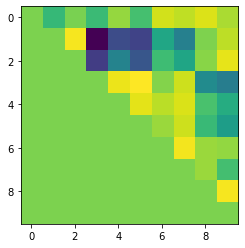

In [46]:
plt.imshow(tri)

In [31]:
jList[0:N]

array([-3.10439744, -3.30708117, -3.53689976, -3.40899648, -3.52824686,
       -3.48777092, -3.49563476, -3.19205147, -3.43139633, -3.21440664])

In [40]:
tri

array([[ 0.        , -1.51476689, -1.53766015, -1.66159319, -1.66314671,
        -1.71294664, -1.56901981, -1.72747263, -1.88857833, -2.01092586],
       [ 0.        ,  0.        , -1.6915924 , -1.79114773, -1.47606976,
        -1.54726842, -1.75190387, -1.78944881, -1.76084998, -1.75325785],
       [ 0.        ,  0.        ,  0.        , -1.54928746, -1.78269138,
        -1.81823069, -1.48869813, -1.92992247, -1.85744723, -1.36671298],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.50418404,
        -1.336894  , -1.4138893 , -1.53411059, -1.56477428, -1.66762713],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.76974587, -1.45759828, -1.61778622, -1.65553642, -1.6686595 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.45418029, -1.68183762, -1.64862001, -1.76517895],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.72590822